# Small data and deep learning
This pratical session proposes to study several techniques to improve training performance in the challenging context where few data and resources are available.

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch.autograd import Variable
from copy import deepcopy
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as vutils
import time
import sys

import warnings
warnings.filterwarnings('ignore')

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, ProgressBar, LRScheduler, WarmRestartLR


# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


## Some helpers

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}_{\text{nolabel}}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |


If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset.)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


To run your experiments, you can use the same local installation as for previous TPs, or otherwise https://colab.research.google.com/.

## Training set creation
__Question 1 (2 points) :__ Propose a dataloader that will only use the first 100 samples of the CIFAR-10 training set. 

*Hint* : You can modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py or use the information from https://pytorch.org/vision/stable/datasets.html

In [ ]:
class cifarloader():
    def __init__(self,train,download,transform, start, end):
        self.dataset = torchvision.datasets.CIFAR10("Data", train = train, download = download, transform = transform)
        self.dataset.data = self.dataset.data[start:end]
        self.dataset.targets = self.dataset.targets[start:end]

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}_{\text{nolabel}}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Testing procedure
__Question 2 (1.5 points) :__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

 The training procedure on small data is diffucult for different reasons. 
- Problem 1 : Noise, missing values, wrong labels, outliers can lean to huge errors of our model's predictions on the test set. 
> Solution 1 : Preprocess carefully the data so that it is as clean as possible. Since the data is small, and assuming that we are in the case where we are able to recognize the label of our data (possible with CIFAR images), wrong labels, missing values and outliers can be preprocessed manually. If it's not the case, we could for example do unsupervised clustering on our data to visualize outliers and wrong labels. In our case the data is already clean.

- Problem 2 : Our trainset might not be representative of the whole data wheteher be it due to a sampling bias or just chance. For example, let's assume that we have a small dataset of $m$ points, and that the large dadaset has $n$ classes of equal proportions. Then the probability that a class is absent from the small dataset is $1$ if $m<n$ and $\leq n(\frac{n-1}{n})^{m}$ otherwise. In our case, with $n=10$ and $m=100$, this probability is less than $0.03\%$. 
> Solution 2.1 : We could first create some metrics in order to assess the representativity of our model. This would give an idea of how much we can trust our model to make predictions on a bigger dataset. A metric would be for example the distance between the sorted labels of our small dataset $L_1 \dots L_m$ and the sorted labels of a dataset with equal proportions of each label $L_1^{*} \dots L_m^{*}$. 
> Solution 2.2 : We can use data augmentation techniques. 

- Problem 3 : Difficult not to overfit. 
> Solution 3 :Be careful of the parameters such as the number of epochs. Do cross validation so that every part of the set is used to train and test.

- Problem 4 : Cross validation can lead to aberrant values for the hyper-parameters if the validation sets are taken too small. The same happens if the training sets are taken too small too. 
> Solution 4 : In our case, we do cross validation with only 3 splits.


# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ResNet-18 model, originally designed for the ImageNet dataset, can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
# code copied from  https://github.com/kuangliu/pytorch-cifar.

'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())



In [ ]:
class Classification_pipeline():
    def __init__(self, net, transform_train, transform_test, params):
        
        self.data_train = cifarloader(train = True, download = True, transform = transform_train, start = 0, end = 100)
        self.data_test = cifarloader(train = False, download = True, transform = transform_test, start = None, end = None)
        
        self.train_loader = torch.utils.data.DataLoader(self.data_train.dataset, batch_size=params['batchsize'], shuffle=True, num_workers=2)
        self.test_loader = torch.utils.data.DataLoader(self.data_test.dataset, batch_size=params['batchsize'], shuffle=True, num_workers=2)
        
        self.params=params
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.net = net.to(self.device)
        
        if self.device == 'cuda':
            self.net = torch.nn.DataParallel(self.net)
            cudnn.benchmark = True

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(net.parameters(), 
                                   lr=params['lr'],
                                   momentum=params['momentum'],
                                   weight_decay = params['weight_decay'])
        
        self.best_acc = 0
        
    def update_params(self,params):
        self.params ['lr'] = params['lr']
        self.params['batch_size'] = params ['batch_size']
        self.params['max_epochs'] = params['max_epochs']
        
    def update_optimizer(self):
        self.optimizer = optim.SGD(self.net.parameters(), 
                                   lr=self.params['lr'],
                                   momentum=self.params['momentum'],
                                   weight_decay = self.params['weight_decay'])
        
    def gridsearch(self,grid_parameters):
        X_train, y_train= self.data_train.dataset.data, self.data_train.dataset.targets
        GridNet = NeuralNetClassifier(
            self.net.double(),
            iterator_train__shuffle=True,
            criterion=nn.CrossEntropyLoss,
            optimizer=torch.optim.SGD,
            device=self.device)

        grid = GridSearchCV(GridNet, grid_parameters, refit=True, cv=KFold(n_splits=3), scoring='accuracy')
        start_time = time.time()
        grid.fit(np.array([X.reshape(3, 32, 32).astype('double') for X in X_train]), np.array(y_train).astype('int64'))
        
        print('Cross-validation finished in ' + str(time.time()-start_time) + ' seconds.')
        print('Best accuracy is '+ str(grid.best_score_))
        print('Best parameters are '+ str(grid.best_params_))
        self.update_params(grid.best_params)
        self.update_optimizer()
        
        self.net.float()
        
        
        return grid.best_params
        
    # Training
    def train_epoch(self,epoch):
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss, acc =  train_loss / (batch_idx+1), 100 * correct / total
        print('\nEpoch %d\nTrain_loss: %.3f | Train_acc: %.3f%% | ' % (epoch+1, loss, acc)) 


    def test(self):
        
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.test_loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.net(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            loss, acc =  test_loss / (batch_idx+1), 100 * correct / total
            print('\nTest_loss: %.3f | Test_acc: %.3f%% | ' % (loss, acc)) 

        # Save checkpoint.
        """acc = 100.*correct/total
        if acc > self.best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            self.best_acc = acc"""
    
    def train(self):
        for epoch in range(self.params['max_epochs']):
            if epoch+1 % 10 == 0 :
                self.optimizer.lr /=10
            self.train_epoch(epoch)
        self.test()

            

In [ ]:
net18 = ResNet18()
params_Resnet18 = {'lr' : 0.05, 'momentum' : 0.9,  'weight_decay' : 5e-4, 'batchsize' : 10, 'max_epochs' : 10 }

In [ ]:
classifier_ResNet18 = Classification_pipeline(net18, transform_train, transform_test, params_Resnet18)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
grid_parameters = {'lr': [0.005, 0.01, 0.05],
              'batch_size': [5, 10, 15],
              'max_epochs': [10, 20, 30, 40]}

In [ ]:
classifier_ResNet18.gridsearch(grid_parameters)
classifier_ResNet18.net.float()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4033       0.0714        2.3087  7.4602


KeyboardInterrupt: 

In [ ]:
classifier_ResNet18.train()

# Transfer learning

We propose to use pre-trained models on a classification task, in order to improve the results of our setting.

## ImageNet features

Now, we will use a model pre-trained on ImageNet and see how well it performs on CIFAR. A list of ImageNet pre-trained models is available on : https://pytorch.org/vision/stable/models.html

__Question 4 (3 points) :__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
EfficientNetB0_pretrained = models.efficientnet_b0(pretrained=True)

for param in EfficientNetB0_pretrained.parameters():
  param.requires_grad = False

#visualize model
#print(EfficientNetB0_pretrained)

In [ ]:
EfficientNetB0_pretrained.classifier = nn.Sequential(
                        nn.Dropout(0.2),
                        nn.Linear(1280, 10))                        

In [ ]:
params_EfficientNet = {'lr' : 0.05, 'momentum' : 0.9,  'weight_decay' : 5e-4, 'batchsize' : 10, 'max_epochs' : 10}

classifier_EfficientNet = Classification_pipeline(EfficientNetB0_pretrained, transform_train, transform_test, params_EfficientNet)

In [ ]:
classifier_EfficientNet.gridsearch(grid_parameters)
classifier_EfficientNet.net.float()

In [ ]:
classifier_EfficientNet.train()

# Incorporating priors
Geometrical priors are appealing for image classification tasks. 
A color image $x$ can be seen as a function: $\mathbb{S}\rightarrow\mathbb{R}^3$, where $\mathbb{S} \subset \mathbb{R}^2$ is the image support.
Let us consider transformations $\mathcal{T}$ of possible inputs $x$. For instance, if an image had infinite support, a translation $\mathcal{T}_a$ of an image $x$ by a shift $a$ would lead to a new infinite-support image $\mathcal{T}_a(x)$, described at each pixel $u$ by :

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

__Question 5 (1.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.



- Problem with translating & scaling : We can miss important objects of the picture that would be used for classification. If we translate and pad, then the borders between the black padding zone and the image could help the model to classify in a wrong way 
> Solution for translation : Limit the translation vector to a few pixels.
> Solution for scaling : Bound the scaling factor
> Solution for padding borders : Zoom and translate. (advised in pytorch documentation)
             
- Problem with rotating : The square is invariant to only 4 rotations. Any rotation that is not a multiple of $\pi/2$ leads to black padding zones on the image.
> Solution : Limit rotations to multiple of $\pi/2$.
> Solution : Zoom and rotate. The zooming factor needs to be larger than $\sqrt{2}$, meaning that we lose a lot of information on the image. 

- Problems with color changes : For some images, the colors of the background can provide the model crucial information on the label. Let's take an irrealistic example. Let's assume our model tries to differentiate asian and african elefants. What might differ between these two images is the landscape in the background. Adding pictures with color changes can confuse our model and prevent him from using information on these background colors.

> Solution: use very light color changes. We could on the other hand to local histogram equalization.

## Data augmentations

__Question 6 (3 points) :__ Propose a set of geometric transformations beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.
You can use tools from https://pytorch.org/vision/stable/transforms.html 

In [ ]:
transform_train_aug = transforms.Compose([
        
        #scale & translation 
        transforms.Resize((38,38)),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.RandomAffine(10),
        transforms.RandomPerspective(),

        #rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    
        #color changes
        transforms.RandomAutocontrast(),
        transforms.RandomEqualize(),
        
        transforms.ToTensor(),        
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test_aug = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
classifier_ResNet18_aug = Classification_pipeline(net, transform_train_aug, transform_test_aug, params_Resnet18)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classifier_ResNet18_aug.gridsearch(grid_parameters)
classifier_ResNet18_aug.net.float() #only necessary if you stop the grid search manually

In [ ]:
classifier_ResNet18_aug.train()

In [ ]:
classifier_EfficientNet_aug = Classification_pipeline(EfficientNetB0_pretrained, transform_train_aug, transform_test_aug, params_EfficientNet)

In [ ]:
classifier_EfficientNet_aug.gridsearch(grid_parameters)
classifier_EfficientNet_aug.net.float()

In [ ]:
classifier_EfficientNet_aug.train()

# Conclusions

__Question 7 (5 points) :__ Write a short report explaining the pros and the cons of each method you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

# Short report

**1. Introduction** 

> The goal of this practical session was to train a supervised model on very small data. We therefore use as a training set the first 100 samples of the CIFAR10 training dataset. We will test our models on the CIFAR10 tesing set which consists of 10 000 samples. The methodology of this TP is the following : We first train a model from scratch (ResNet18), incorporating some solutions to the problems of small data training that we discussed in the first question. We then train the last layer only of a pretrained model, EfficientNetb0. We then train these same models after having performed data augmentation on the small data to assess it's. We summarize the performances of each model.



**2. TrainingResNet18 from scratch on a small dataset**


ResNet-18 is a residual network with 18 layers.


I optimized the weights using Stochastic Gradient Descent and the hyper parameters of a Grid Search. These parameters turned out to be a learning rate of 0.005, a momentum of 0.9, a batch size of 5, number of epochs to 10. I devided the learning rate by 10 every  epochs to avoid over-fitting. The accuracy is $21.91\%$ on the test set.

>Pros : With small data,  Grid Search is feasible with reasonable training time using any of Google Colab's GPUs. Training is also very fast with GPU. 

>Cons : There is a lot of overfitting. There are too many parameters to learn the biggest features of our data. On larger datasets, this model becomes more accurate but takes more time to train.  

**3. Training the last layer of EfficientNet on a small dataset**

EfficientNet is a lightweight convolutional neural network architecture achieving the state-of-the-art accuracy that rely on AutoML and compound scaling. As it has an order of magnitude less parameters, I thought it was perfectly adapted to the small dataset problem as it should help reduce overfitting. I optimized the weights using Stochastic Gradient Descent and the hyper parameters of a Grid Search. These parameters turned out to be a learning rate of 0.05, a momentum of 0.9, a batch size of 15, number of epochs to 10. I devided the learning rate by 10 every 20 epochs to avoid over-fitting. The accuracy is $16.41\%$ on the test set.

>Pros : Less parameters helps reduce overfitting.  Less training time as only a single layer is trained. As the model is pretrained and has already learned the bigger features of the images, parameter tuning can be performed only on the last layer, meaning grid search can be performed in correct execution time.

>Cons : We need the pretrained model for the architecture, so we cannot use this method for any architecture we want.

**4. Augmenting the dataset with transform techniques**


As we have a small number of samples, we used data augmentation.

I tried translations and scalings, rotations with multiples of $\pi/2$, color changes, normalization. 

>Pros : This helps our model to learn new types of inputs that might be present in the test set. 

>Cons : Looking for the optimal transformations takes time, as the optimal transformations are often counter-intuitive. This requires a good understanding of our data. We also cannot perform gridsearch as we are directly changing the data and not parameters of our model. I did not manage to find transformations that increased the accuracy of our model. This is probably because the most important transformations are the ones I had already used in the first questions.

**4. Summary**

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet 18  |10| $36\%$ | $21.91\%$ |
|   ResNet 18 augmented  |10| $49\%$ | $21.68\%$ |
|   EfficientNet_pretrained  |40| $48\%$ | $16.41\%$ |
|   EfficientNet_pretrained_augmented  |40| $44\%$ | $16.40\%$ |

**4. Conclusion**

I am aware that my experiments are not very conclusive as I failed to show that some used methods such as Data augmentation or transfer learning can improve test accuracy. On the other hand even though I lacked the time to use these tools efficiently in this TP, I learned how to implement them and will not hesitate to use them when I am confronted to small data problems and have time to improve my models. 

# Weak supervision

__Bonus \[open\] question (up to 4 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}_{\text{nolabel}}\cup\mathcal{X}_{\text{train}}$ to train a model (a subset of $\mathcal{X}_{\text{nolabel}}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In this questio I will use a semi-supervised model that we designed in another course, GraphsML. This question enables me to test this model in the case where the dataset is not the same one proposed by the professor. The next cell is a paragraph explaining this model and __entirely__ written by our professor. 

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels
from sklearn.utils import shuffle
import time
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

In [ ]:
"""
Define parameters for face recognition with HFS
"""
params_ssl = {}
params_ssl['laplacian_regularization'] = 0.75
params_ssl['var'] = 10.0
params_ssl['eps'] = 1.
params_ssl['k'] = None
params_ssl['laplacian_normalization'] = 'unn'
params_ssl['c_l'] = 0.9
params_ssl['c_u'] = 0.1

In [ ]:
def compute_hfs(L, Y, soft=False, **params):
    """
    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    # ...
    l_idx = Y != 0
    u_idx = Y ==0
    
    # we encode using the solution provided here https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy 
    target_indices = (Y[l_idx]-1).astype(int)    
    y = np.zeros((num_samples,num_classes))
    M = 2*np.eye(num_classes)-np.ones((num_classes,num_classes))
    
    y[l_idx]= M[target_indices]
    
    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        
        f_l = M[target_indices]
        f_u = - np.linalg.inv(L[:,u_idx][u_idx])@(L[:,l_idx][u_idx]@f_l)
        f = np.zeros((num_samples,num_classes))
        f[l_idx]=f_l
        f[u_idx]=f_u
        
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        u = np.zeros(L.shape[0]) 
        u[l_idx] = params['c_l']
        u[u_idx] = params['c_u']
        C = np.diag(u)         
        f = np.linalg.inv(np.linalg.inv(C)@L + np.eye(num_samples))@y 

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f,axis=1)+1
    return labels, f


In [ ]:
transform_ssl = transforms.Compose([
    transforms.RandomAutocontrast(),
    transforms.RandomEqualize(),
    transforms.Grayscale(),
    transforms.GaussianBlur(kernel_size=(9,9)),
    transforms.ToTensor(),
])

size = 2000
data_train_full = cifarloader(train = True, download = True, transform = transform_ssl, start = None, end = size )


X_train, y_train= data_train_full.dataset.data, data_train_full.dataset.targets

Files already downloaded and verified


In [ ]:
np.random.seed(15)
X_train_shuffled, y_train_shuffled = shuffle(X_train,y_train)
X_train_shuffled = X_train_shuffled.reshape(size,-1)/255


In [ ]:
time_start = time.time()
L = build_laplacian_regularized(X_train_shuffled, 
                                params_ssl['laplacian_regularization'], 
                                params_ssl['var'], 
                                params_ssl['eps'], 
                                params_ssl['k'], 
                                params_ssl['laplacian_normalization'])

__Now let's plot the performance of the model with respect to the size of the training set.__

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  7.80it/s]


execution time =  249.538245677948


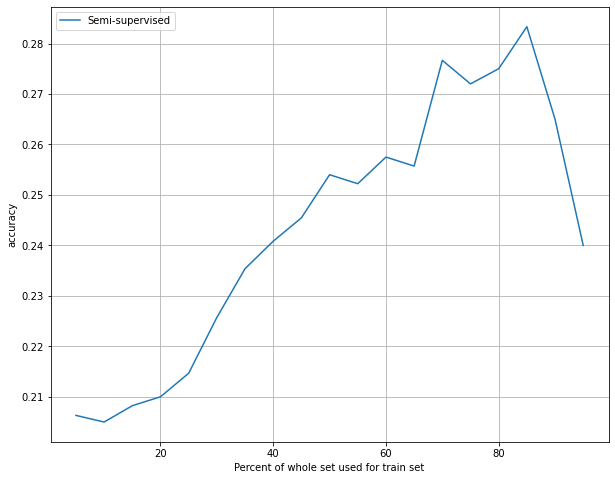

In [ ]:
# Run HFS

test_labels = np.zeros(size)
ones=np.ones(size)
accuracy_semi_supervised = []
for i in tqdm(np.linspace(0,1,21)[1:-1]) :
    ind = int(i*size)
    test_labels[:ind]=y_train_shuffled[:ind]+ones[:ind] 
    predicted_labels_unsupervised, f_a = compute_hfs(L, test_labels, soft=False, **params_ssl)
    accuracy_augmented = np.equal(predicted_labels_unsupervised[ind:], y_train_shuffled[ind:]+ones[ind:]).mean()
    accuracy_semi_supervised.append(accuracy_augmented)

print('execution time = ', time.time()-time_start)

x = 100*np.linspace(0,1,21)[1:-1]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x,accuracy_semi_supervised,label='Semi-supervised')
ax.set(xlabel='Percent of whole set used for train set', ylabel='accuracy')
ax.plot()
ax.grid()
ax.legend()
plt.show()

Semi supervised learning seems to perform correctly on very small training sets, with accuracies above $20\%$ when $5\%$ of the dataset is used, but fails to give good accuracies for larger training sets given the amount of data we have. (less than $30 \%$ accuracy when the training set is $80 \%$ of the whole set.)